## 📘 **Ödev: Veri Önişleme Görevi (10 Adım)**

### 🧹 1. **Eksik Değer Analizi**

* Hangi sütunlarda eksik veri var?
* Her bir sütun için eksik oranı nedir?

### 🧼 2. **Eksik Verilerin Tamamlanması**

* Sayısal değişkenleri `SimpleImputer` ile doldur
* Kategorik değişkenleri en sık kategori ile doldur

### 📊 3. **Aykırı Değer Analizi**

* `spending` ve `monthly_income` değişkenleri için boxplot çiz
* IQR yöntemine göre aykırı değerleri tespit et

### ✂️ 4. **Aykırı Değer İşleme**

* Winsorizing veya clip yöntemiyle aykırıları baskıla

### 🔣 5. **Kategorik Verileri Kodla**

* `gender`: LabelEncoder
* `city`: One-Hot Encoding

### ⚖️ 6. **Sayısal Değişkenleri Ölçekle**

* `StandardScaler` veya `RobustScaler` kullan
* Sadece sayısal sütunları ölçekle

### 📈 7. **Log Dönüşüm Uygula**

* `spending` değişkenine `np.log1p()` uygula
* Dağılımını görselleştir

### 🤖 8. **Model Kur**

* Bağımlı değişken: `spending_log`
* Lineer regresyon modeli kur ve değerlendir (`R²`, `MSE`)

### 📉 9. **Modeli Değerlendir**

* R² değeri ne çıktı? Yorumla.
* Modelin eksik yönlerini düşün

### 💬 10. **Ekstra Bonus: random forest**

* r2 skorun eksik çıktı. üzülme.
* Rondom Forest ile dene

---



In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 1. Veri setini oluştur
np.random.seed(42)
n = 120

df = pd.DataFrame({
    "age": np.random.randint(18, 65, size=n),
    "gender": np.random.choice(["Male", "Female"], size=n),
    "monthly_income": np.random.normal(8000, 2500, size=n),
    "city": np.random.choice(["İstanbul", "Ankara", "İzmir"], size=n),
    "purchase_score": np.random.randint(1, 100, size=n),
})

# Eksik değerler ekle
df.loc[np.random.choice(n, 10, replace=False), "monthly_income"] = np.nan
df.loc[np.random.choice(n, 8, replace=False), "city"] = np.nan

# anlamlı target: harcama miktarı
df["spending"] = df["monthly_income"] * 0.8 + df["age"] * 30 + np.random.normal(0, 700, size=n)

# Aykırı değer ekle
df.loc[3, "spending"] = 60000
df.loc[10, "monthly_income"] = 50000

df.head(10)

,age,gender,monthly_income,city,purchase_score,spending
0,56,Female,7839.054873,İstanbul,34,9102.721298
1,46,Female,8862.255838,İstanbul,7,8295.479442
2,32,Male,7799.781662,İstanbul,68,7603.415203
3,60,Male,NaN,İstanbul,58,60000.000000
4,25,Female,11583.788718,İzmir,75,12172.247540
5,38,Female,10664.484271,Ankara,29,10455.289855
6,56,Female,NaN,NaN,36,NaN
7,36,Male,11700.821403,Ankara,89,9771.778814
8,40,Male,13396.821308,İzmir,21,10792.944623
9,28,Male,11079.445942,İzmir,36,9845.981299


In [37]:
# 1. Eksik Değer Analizi
missing_counts = df.isnull().sum()
missing_ratios = df.isnull().mean()

missing_info = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing Ratio": missing_ratios
})

missing_info

,Missing Count,Missing Ratio
age,0,0.000000
gender,0,0.000000
monthly_income,10,0.083333
city,8,0.066667
purchase_score,0,0.000000
spending,9,0.075000


Aşağıdaki sütunlarda eksik veriler bulunmaktadır:

| Sütun Adı        | Eksik Sayısı | Eksik Oranı |
| ---------------- | ------------ | ----------- |
| `monthly_income` | 10           | %8.33       |
| `city`           | 8            | %6.67       |
| `spending`       | 9            | %7.5        |


In [38]:
# 2. Eksik Verilerin Tamamlanması

# Sayısal veriler: monthly_income, spending
#Sayısal değişkenleri SımpleImputer ile doldur
num_imputer = SimpleImputer(strategy="mean")
df[["monthly_income", "spending"]] = num_imputer.fit_transform(df[["monthly_income", "spending"]])

#Kategorik değişkenleri en sık kategori ile doldur
cat_imputer = SimpleImputer(strategy="most_frequent")
df[["city"]] = cat_imputer.fit_transform(df[["city"]])

# Eksik değer kalmış mı kontrol edelim
df.isnull().sum()

,0
age,0
gender,0
monthly_income,0
city,0
purchase_score,0
spending,0


Tüm eksik değerler başarıyla dolduruldu. Artık veri setinde eksik veri bulunmuyor.

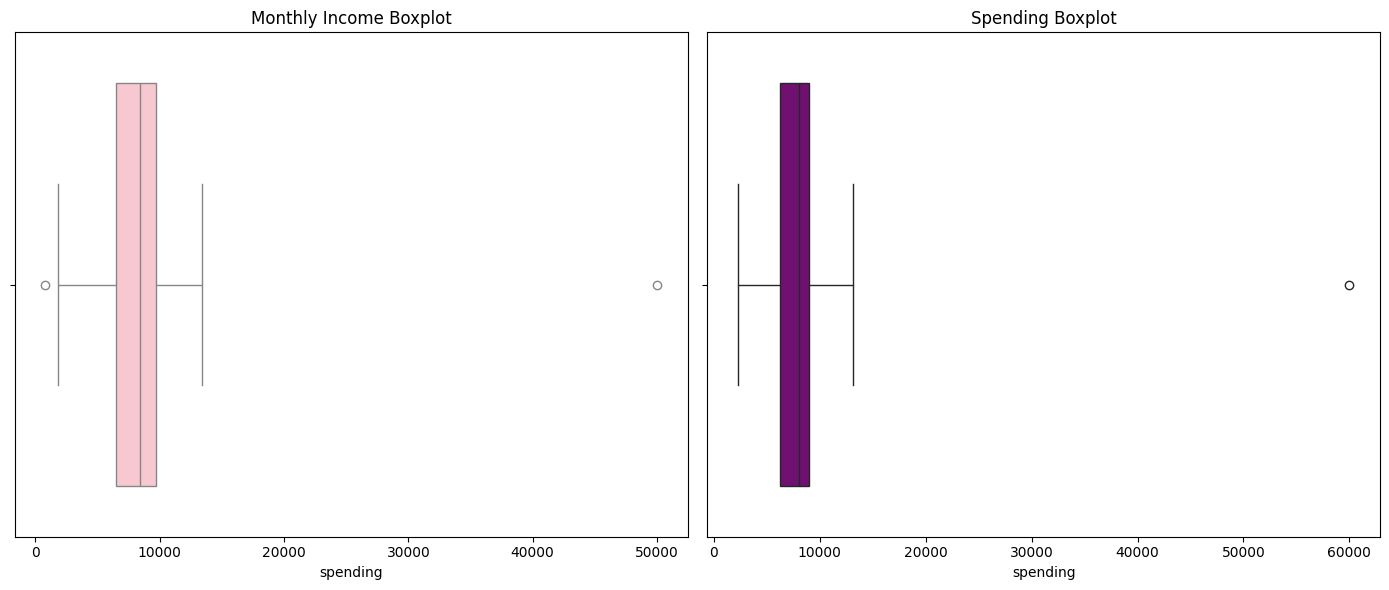

In [39]:
# 3. Aykırı Değer Analizi

#spending ve monthly_income değişkenleri için Boxplot çizimi
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df["monthly_income"], color='pink' ,)
plt.xlabel("spending")
plt.title("Monthly Income Boxplot")

plt.subplot(1, 2, 2)
sns.boxplot(x=df["spending"], color='purple' ,)
plt.xlabel("spending")
plt.title("Spending Boxplot")

plt.tight_layout()
plt.show()



In [40]:

# IQR yöntemi ile aykırı değerleri tespiti
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

outliers_income = detect_outliers_iqr(df["monthly_income"])
outliers_spending = detect_outliers_iqr(df["spending"])

len(outliers_income), len(outliers_spending)

(2, 1)

* monthly_income değişkeninde 2 aykırı değer

* spending değişkeninde 1 aykırı değer tespit edilmiştir

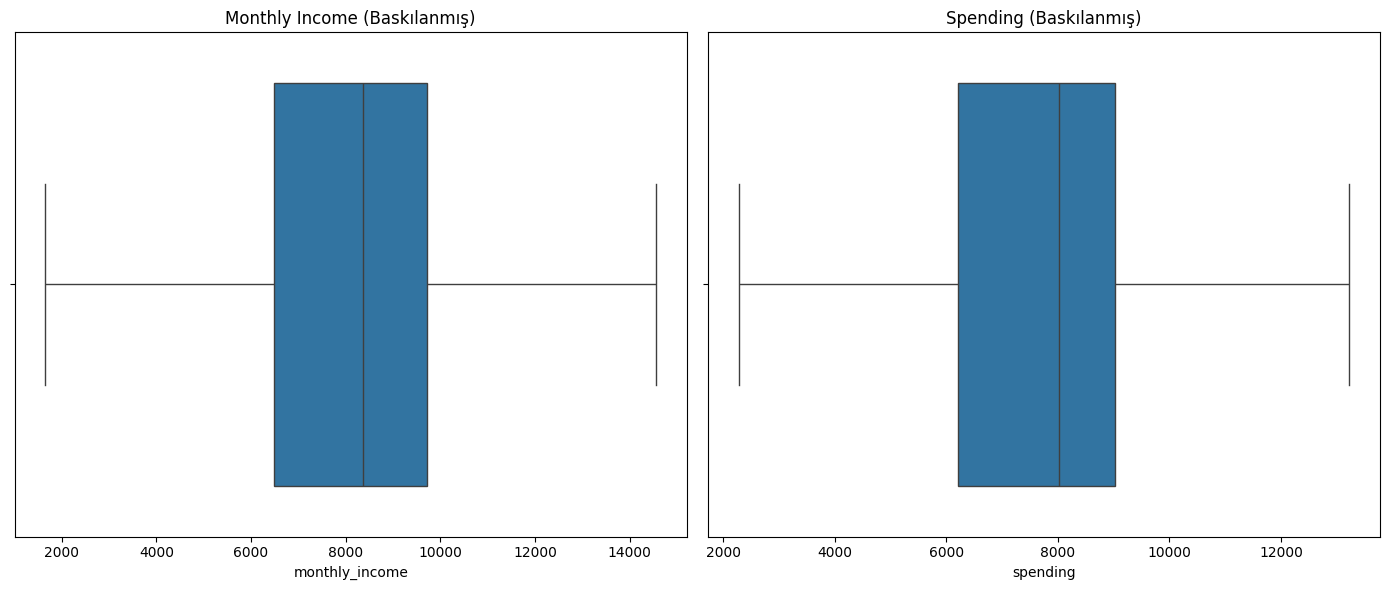

In [41]:
# 4. Aykırı Değerleri Baskılama (Winsorizing / clip yöntemi)

def clip_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower=lower, upper=upper)

df["monthly_income"] = clip_outliers(df["monthly_income"])
df["spending"] = clip_outliers(df["spending"])

# Yeni boxplot çizimi kontrol
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df["monthly_income"])
plt.title("Monthly Income (Baskılanmış)")

plt.subplot(1, 2, 2)
sns.boxplot(x=df["spending"])
plt.title("Spending (Baskılanmış)")

plt.tight_layout()
plt.show()


Yukarıdaki kutu grafiklerinde artık aykırı değerler baskılanmış durumda ve daha dengeli bir dağılım görülüyor.

* 5. Kategorik Verileri Kodla
* gender: LabelEncoder
* city: One-Hot Encoding

In [42]:
#gender:labelencoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df["gender_label"]=le.fit_transform(df["gender"])
print(df[["gender_label" ,"gender"]])

     gender_label  gender
0               0  Female
1               0  Female
2               1    Male
3               1    Male
4               0  Female
..            ...     ...
115             0  Female
116             1    Male
117             1    Male
118             1    Male
119             1    Male

[120 rows x 2 columns]


In [43]:
#city:one-hot encoding
df = pd.get_dummies(df, columns=['city'], drop_first=True)
print(df)

     age  gender  monthly_income  purchase_score      spending  gender_label  \
0     56  Female     7839.054873              34   9102.721298             0   
1     46  Female     8862.255838               7   8295.479442             0   
2     32    Male     7799.781662              68   7603.415203             1   
3     60    Male     8373.833079              58  13227.392455             1   
4     25  Female    11583.788718              75  12172.247540             0   
..   ...     ...             ...             ...           ...           ...   
115   25  Female    11003.451111              67   8953.502210             0   
116   29    Male     8374.584291              45   7619.763799             1   
117   51    Male     8352.268420              13   7877.454523             1   
118   50    Male     8886.048963              92   8944.125048             1   
119   40    Male     3299.218529              58   4072.938297             1   

     city_İstanbul  city_İzmir  
0     

### Sayısal Değişkenleri Ölçekle
* StandardScaler veya RobustScaler kullan
* Sadece sayısal sütunları ölçekle

In [44]:
#sayısal verileri ölçekle
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sayısal_sütun = ["age", "monthly_income", "purchase_score"]
df[sayısal_sütun] = scaler.fit_transform(df[sayısal_sütun])

### 7. Log Dönüşüm Uygula
* spending değişkenine np.log1p() uygula
* Dağılımını görselleştir

In [45]:
#spending değişkenine log uygula
df["spending_log"]=np.log1p(df["spending"])
print(df)

          age  gender  monthly_income  purchase_score      spending  \
0    1.114092  Female       -0.097144       -0.521209   9102.721298   
1    0.387510  Female        0.306031       -1.459907   8295.479442   
2   -0.629704    Male       -0.112619        0.660855   7603.415203   
3    1.404725    Male        0.113576        0.313189  13227.392455   
4   -1.138312  Female        1.378404        0.904221  12172.247540   
..        ...     ...             ...             ...           ...   
115 -1.138312  Female        1.149732        0.626088   8953.502210   
116 -0.847679    Male        0.113872       -0.138777   7619.763799   
117  0.750801    Male        0.105079       -1.251307   7877.454523   
118  0.678143    Male        0.315406        1.495253   8944.125048   
119 -0.048439    Male       -1.885988        0.313189   4072.938297   

     gender_label  city_İstanbul  city_İzmir  spending_log  
0               0           True       False      9.116439  
1               0        

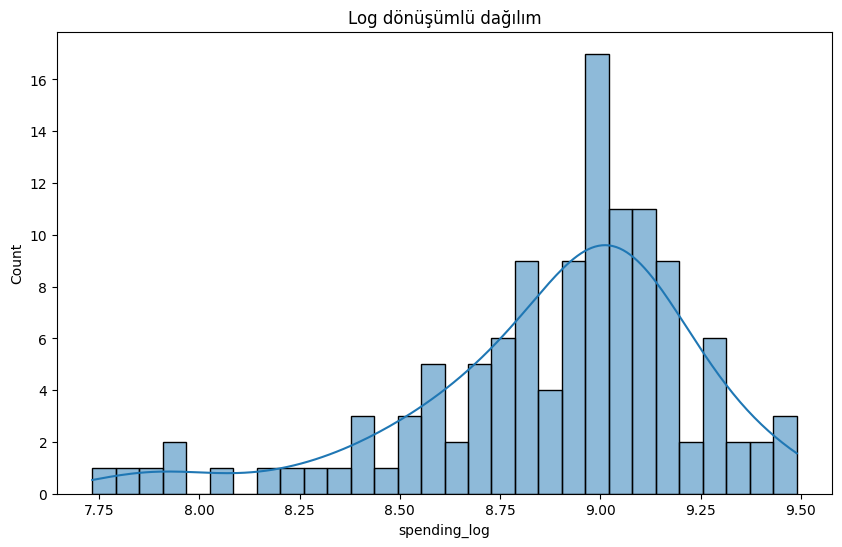

In [46]:
#dağılım görseli
plt.figure(figsize=(10, 6))
sns.histplot(df["spending_log"], bins=30, kde=True)
plt.title("Log dönüşümlü dağılım")
plt.show()

 ### 8. Model Kur

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Özellik ve hedef değişkenlerin seçimi
X = df[["age", "monthly_income", "purchase_score", "gender_label", "city_İstanbul", "city_İzmir"]]
y = df["spending_log"]

# Eğitim ve test verisi olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli kur ve eğit
model = LinearRegression()
model.fit(X_train, y_train)

# Test seti üzerinde tahmin yap
y_pred = model.predict(X_test)

# Model performansını değerlendirme
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R² Skoru:", r2)
print("MSE (Mean Squared Error):", mse)


R² Skoru: 0.6344146112725065
MSE (Mean Squared Error): 0.053528397330048265


### 9. Modeli Değerlendir

🔹 R² Skoru: 0.634

Bu skor, bağımlı değişken olan spending_log’un varyansının yaklaşık %63.4’ünün model tarafından açıklandığını gösteriyor.

Yani model, harcama miktarını orta düzeyde .

🔹 MSE: 0.0535

Ortalama kare hatası düşük görünüyor, bu da tahminlerin hedef değere çok uzak olmadığını gösteriyor (log dönüşümüne göre).

* Yorumu:
Model makul bir performans sergiliyor ancak daha iyi sonuçlar için geliştirmeye açık.

Özellikle lineer regresyon doğrusal ilişkileri modellediği için, karmaşık veya doğrusal olmayan desenleri kaçırabilir.

* Eksik Yönler:
Doğrusal olmayan ilişkiler için uygun değil (spending gelirle doğrusal olmayabilir).

Daha fazla değişken eklenebilir

### 10. Ekstra Bonus: Random Forest

In [55]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Random Forest R² Skoru:", r2_rf)
print("Random Forest MSE:", mse_rf)


Random Forest R² Skoru: 0.8103697235078949
Random Forest MSE: 0.027765345932472558


🔹 R² Skoru: 0.810
Bu, modelin bağımlı değişken olan spending_log’un varyansının %81’ini açıkladığını gösteriyor.

Yani Random Forest, lineer regresyon modeline göre çok daha başarılı oldu.

Doğrusal olmayan ilişkileri daha iyi yakalayabildiği açıkça görülüyor.

🔹 MSE (Mean Squared Error): 0.0277
Hata oranı ciddi şekilde azalmış.

Tahmin edilen değerler, gerçek değerlere daha yakın hale gelmiş.